In [89]:
# import warnings
# warnings.filterwarnings('ignore')

# North Wind Trading Co.

## Hypothesis:

1. Do discounts affect the quantity ordered.
1. Processing time equals the mean.
1. Are Reorder levels adequate
1. 

## SQL Queries Using SqLite3
### Northwind ERD
<img src='northwind_ERD.png'>

### Importing sqlite database

In [1]:
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

### List of Tables

In [2]:
c.execute('''
SELECT name
FROM sqlite_master
WHERE type='table';
''').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

## SQL for EDA
List of the columns in OrderDetail

In [3]:
c.execute('''
PRAGMA table_info(OrderDetail)
''').fetchall()

[(0, 'Id', 'VARCHAR(8000)', 0, None, 1),
 (1, 'OrderId', 'INTEGER', 1, None, 0),
 (2, 'ProductId', 'INTEGER', 1, None, 0),
 (3, 'UnitPrice', 'DECIMAL', 1, None, 0),
 (4, 'Quantity', 'INTEGER', 1, None, 0),
 (5, 'Discount', 'DOUBLE', 1, None, 0)]

SQL has some native functions that can be used for EDA, which we will explor here. The following function that we will be using will be:

* Min
* Max
* Average

In [4]:
c.execute('''
SELECT Discount, COUNT(Discount)
FROM OrderDetail
GROUP BY Discount
ORDER BY Discount;
''').fetchall()

[(0.0, 1317),
 (0.01, 1),
 (0.02, 2),
 (0.03, 3),
 (0.04, 1),
 (0.05, 185),
 (0.06, 1),
 (0.1, 173),
 (0.15, 157),
 (0.2, 161),
 (0.25, 154)]

In [5]:
c.execute('''
SELECT AVG(Discount), MIN(Discount), MAX(Discount)
FROM OrderDetail;
''').fetchall()

[(0.05616705336426916, 0.0, 0.25)]

Avg: .06

Min: 0.0

Max: 0.25

The average discount per order is 6%, but looking at the orders. As there is no native median function is SQL we will do the remaining EDA using Pandas and Numpy.

## Importing Pandas & Numpy for EDA

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
orders = pd.read_sql_query('''
SELECT *
FROM OrderDetail;
''', conn)

In [8]:
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [9]:
orders.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [10]:
orders.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


### Visual EDA Using Matplotlib & Seaborn

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [12]:
discount_false = orders[orders['Discount'] == 0.0]
discount_true = orders[orders['Discount'] > 0.0]

In [13]:
discount_false.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [14]:
discount_true.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


### Histograms

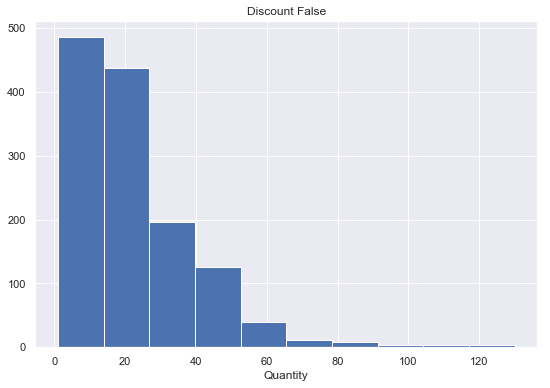

In [15]:
_ = plt.figure(figsize=(9,6))
_ = plt.hist(discount_false['Quantity'])
_ = plt.title('Discount False')
_ = plt.xlabel('Quantity')
plt.show()

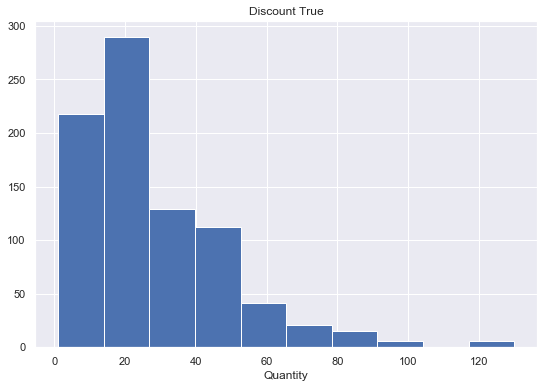

In [16]:
_ = plt.figure(figsize=(9,6))
_ = plt.hist(discount_true['Quantity'])
_ = plt.title('Discount True')
_ = plt.xlabel('Quantity')
plt.show()

### Bee Swarm Plot

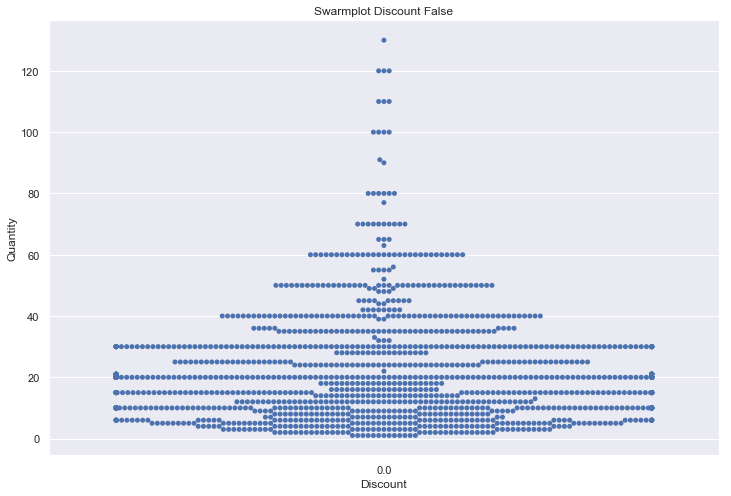

In [17]:
sns.set()
plt.figure(figsize=(12, 8))
sns.swarmplot(x=discount_false['Discount'], y=discount_false['Quantity'])
plt.title('Swarmplot Discount False')
plt.show()

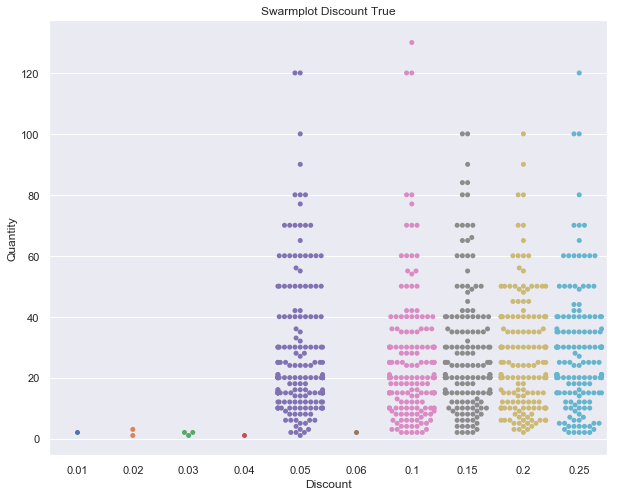

In [18]:
plt.figure(figsize=(10, 8))
sns.swarmplot(x=discount_true['Discount'], y=discount_true['Quantity'])
plt.title('Swarmplot Discount True')
plt.show()

### Empirical Cumulative Distribution Functions (ECDF)

In [19]:
def ecdf(data):
    '''
    Computes the ECDF for a given dataset.
    
    data: a list or array.
    
    returns: x, y
    '''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    
    return x, y

In [20]:
quantity_x, quantity_y = ecdf(discount_false['Quantity'])

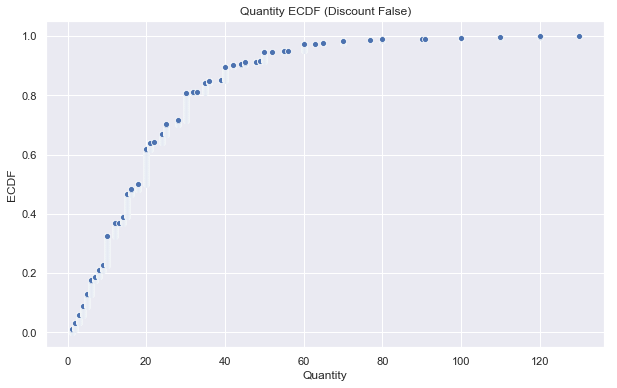

In [21]:
_ = plt.figure(figsize=(10,6))
_ = sns.scatterplot(x=quantity_x, y=quantity_y)
_ = plt.title('Quantity ECDF (Discount False)')
_ = plt.xlabel('Quantity')
_ = plt.ylabel('ECDF')

plt.show()

In [22]:
dis_true_x, dis_true_y = ecdf(discount_true['Quantity'])

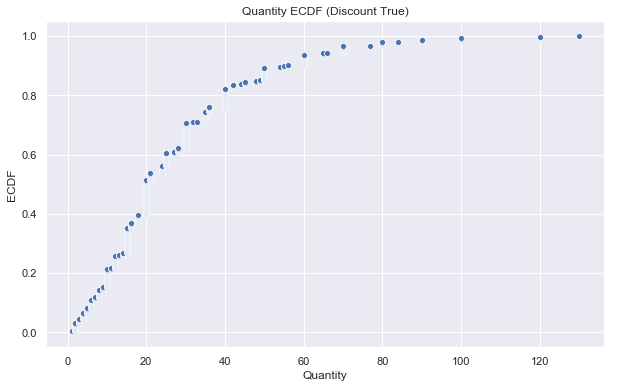

In [23]:
_ = plt.figure(figsize=(10,6))
_ = sns.scatterplot(x=dis_true_x, y=dis_true_y)
_ = plt.title('Quantity ECDF (Discount True)')
_ = plt.xlabel('Quantity')
_ = plt.ylabel('ECDF')

plt.show()

### Box Plots

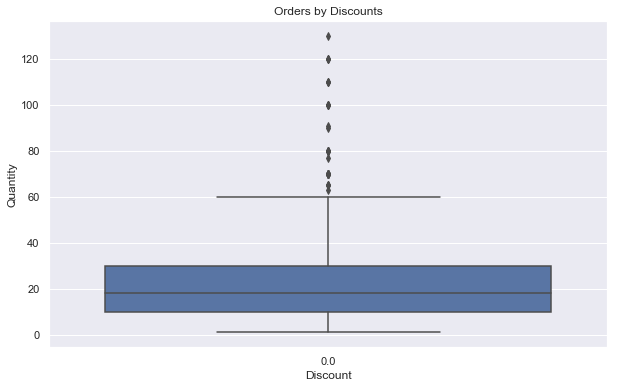

In [24]:
_ = plt.figure(figsize=(10,6))
_ = sns.boxplot(x=discount_false['Discount'], y=discount_false['Quantity'])
_ = plt.title('Orders by Discounts')
plt.show()

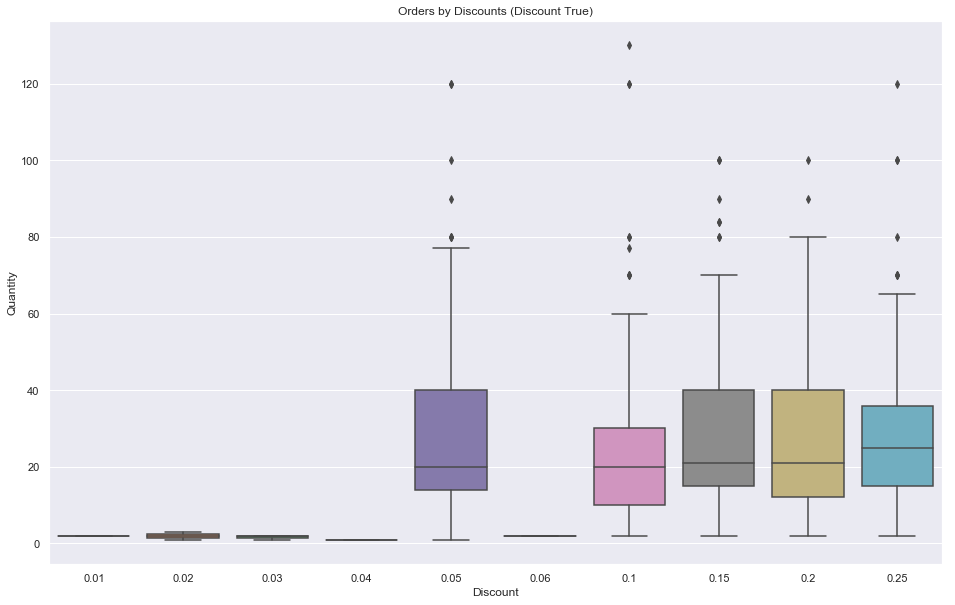

In [25]:
_ = plt.figure(figsize=(16, 10))
_ = sns.boxplot(x=discount_true['Discount'], y=discount_true['Quantity'])
_ = plt.title('Orders by Discounts (Discount True)')
plt.show()

Add explanations to box plots.

From the EDA we can see that discounts in increments of 5% have more orders.

### Checking for Covariance

In [26]:
discount_categories = pd.get_dummies(orders['Discount'], columns='Discount')
orders_new = pd.concat([orders, discount_categories], axis=1)
orders_new.drop(columns='Discount', inplace=True)

In [27]:
def pearson_r(data1, data2):
    '''
    Computes the pearson correlation between two datasets
    
    returns: covariance
    '''
    return np.cov(data1, data2)[0,1]

In [28]:
discount_corr = pearson_r(discount_false['Discount'], discount_false['Quantity'])
print(f' Pearson Correlation w/ No Discounts: {discount_corr}')

 Pearson Correlation w/ No Discounts: 0.0


In [29]:
no_discount_corr = pearson_r(discount_true['Discount'], discount_true['Quantity'])
print(f' Pearson Correlation w/ No Discounts: {no_discount_corr}')

 Pearson Correlation w/ No Discounts: 0.048496534104356066


### Hacker Statistics

Generate samples of quantities form the OrderDetail table then compare them to the original data.

In [30]:
def replicate(data, func, size=1):
    '''
    Creates a random sample from data using numpy's
    np.random.choice() method.
    
    data: a dataset to generate replicates
    func: type of func to pass(np.mean, np.median, np.std)
    size: how many samples to generate
    '''
    sample = np.random.choice(data, len(data))
    return func(sample)

In [31]:
def simulate(data, func, size=1):
    '''
    Generates multiple replicates using the replicate function.
    
    data: a dataset to generate replicates
    func: type of func to pass(mean, median, std)
    size: how many samples to generate    
    '''
    # initialize empty array to store replicates
    replicas = np.empty(shape=size)
    
    # for loop to generate a replica for the given size
    for i in range(size):
        replicas[i] = replicate(data, func)
        
    return replicas

Standard Error of Mean: 0.4096687388075916
Standard deviation: 0.41177918756510773
Mean: 23.81319113689095


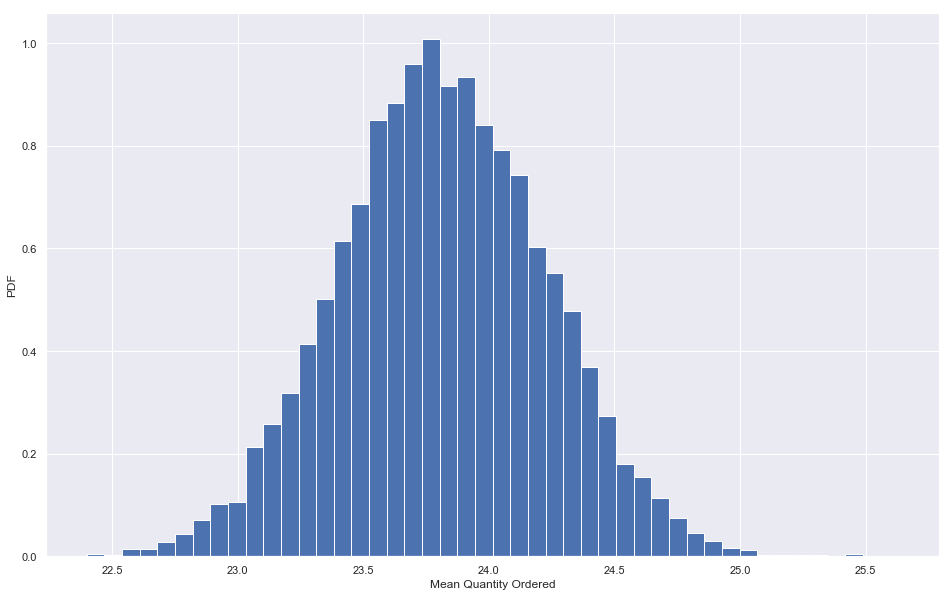

In [32]:
quantity = orders['Quantity']
# take 10000 mean replicas from Quantity
qty_replicas = simulate(quantity, np.mean, 10000)

# computing the standard error of the mean
sem = np.std(quantity) / np.sqrt(len(quantity))
print(f'Standard Error of Mean: {sem}')

std_replicas = np.std(qty_replicas)
print(f'Standard deviation: {std_replicas}')
print(f'Mean: {np.mean(qty_replicas)}')

# Histogram to show results
_ = plt.figure(figsize=(16, 10))
_ = plt.hist(qty_replicas, bins=int(np.sqrt(len(quantity))), density=True)
_ = plt.xlabel('Mean Quantity Ordered')
_ = plt.ylabel('PDF')

plt.show()

### Confidence Interval

Computing the 95% confidence interval.

In [33]:
np.percentile(qty_replicas, [2.5, 97.5])

array([23.00973318, 24.61856148])

### Linear Regression 

In [34]:
def lin_reg_sample_pairs(x, y, size=1):
    '''
    Perform pair sampling for linear regression
    
    size: number of samples
    '''
    
    # create indices for the same size as x.
    indices = np.arange(len(x))
    
    # empty arrays to store slopes and intercepts
    slopes = np.empty(size)
    intercepts = np.empty(size)
    
    # for loop to generate replicas
    for i in range(size):
        index = np.random.choice(indices, size=len(x))
        sample_x, sample_y = x[indices], y[indices]
        slopes[i], slopes[i] = np.polyfit(sample_x, sample_y, deg=1)
        
    return slopes, intercepts

In [35]:
# generate samples of slopes and intercepts using the above function.
qty_m, qty_b = lin_reg_sample_pairs(orders['Discount'], orders['Quantity'], size=1000)

In [36]:
# the confidence interval for slope and intercept
print(f'Confidence interval for slope: {np.percentile(qty_m, [2.5, 97.5])}')

Confidence interval for slope: [22.16682896 22.16682896]


In [37]:
def permutation_data(data1, data2):
    '''
    Generate a permuation sample from two datasets.
    
    data1: a 1D array
    data2: a 1D array
    
    returns permuted_data1, permuted_data2
    '''
    
    #concatenate 2 datasets
    data = np.concatenate((data1, data2))
    
    # permute the concatenated array
    permuted_array = np.random.permutation(data)
    
    # split the data into the original sizes
    perm_data1 = permuted_array[:len(data1)]
    perm_data2 = permuted_array[len(data1):]
    
    return perm_data1, perm_data2

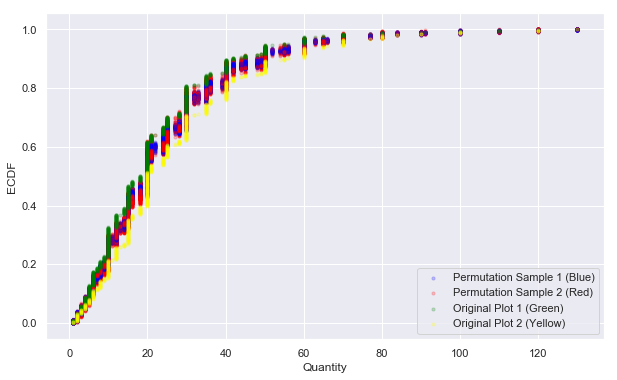

In [38]:
plt.figure(figsize=(10, 6))
for sample in range(50):
    permuted1, permuted2 = permutation_data(discount_false['Quantity'], discount_true['Quantity'])
    
    #computing ECDFs for permuted1 and permuted2
    x1, y1 = ecdf(permuted1)
    x2, y2 = ecdf(permuted2)
    
    #plotting the ECDFs
    perm_plot1 = plt.scatter(x1, y1, c='blue', s=10, alpha=0.2)
    perm_plot2 = plt.scatter(x2, y2, c='red', s=10, alpha=0.2)
    
# plot for the original dataset
ox1, oy1 = ecdf(discount_false['Quantity'])
ox2, oy2 = ecdf(discount_true['Quantity'])

orig_plot1 = plt.scatter(ox1, oy1, c='green', s=10, alpha=0.2)
orig_plot2 = plt.scatter(ox2, oy2, c='yellow', s=10, alpha=0.2)
_ = plt.xlabel('Quantity')
_ = plt.ylabel('ECDF')
_ = plt.legend([perm_plot1, perm_plot2, orig_plot1, orig_plot2] , 
               ['Permutation Sample 1 (Blue)', 'Permutation Sample 2 (Red)', 
                'Original Plot 1 (Green)', 'Original Plot 2 (Yellow)'], loc=4)

plt.show()

The distributions of the datasets [Permutation Sample 1, Permutation Sample 2, Original 1, Original 2] have the same distribution because the points overlap. This is verified by the histogram and ECDFs created earlier in the notebook.

In [39]:
def permutation_replicates(data1, data2, func, size=1):
    '''
    Generate multiple permutation replicates from a sample distribution.
    
    data1: a numpy array
    data2: a numpy array
    func: a numpy function(np.mean, np.std, np.var, etc...)
    size: number of replicates to generate
    
    returns: perm_replicates
    '''
    
    # initialize an empty array with the size parameter
    replicates = np.empty(size)
    
    # for loop to generate replicates to put into replicates array
    for i in range(size):
        sample1, sample2 = permutation_data(data1, data2)
        
        # Compute the test statistic for each iteration and then add
        # to replicates array
        replicates[i] = func(sample1, sample2)
        
    return replicates

In [40]:
def diff_of_mean(data1, data2):
    '''
    Calculate the difference of means between two means.
    
    data1: an array
    data2: an array
    
    returns: diff
    '''
    
    diff = np.mean(data1) - np.mean(data2)
    
    return diff

## Hypothesis Testing

In [41]:
# the pearson correlation between quantity and discount
qty_corr = pearson_r(discount_true['Discount'], discount_true['Quantity'])
print(f'Pearson Coefficient: {qty_corr}')

Pearson Coefficient: 0.048496534104356066


> H0: $\rho_0 \geq \rho_1$
The pearson correlation between discounts and quantities ordered is greater than or equal 4.84%


> H1: $\rho_0 < \rho_1$
The pearson correlation between discounts and quantities ordered is less than 4.84%

In [42]:
# initialize empty permutation array of 10000
permutation_arr = np.empty(10000)

# for loop to create samples of the pearson coefficient
for i in range(10000):
    
    #quantity & discount pearson coefficient samples
    qty_sample = np.random.permutation(orders['Quantity'])
    
    # calculates the pearson coeffificent for each sample 
    # distribution and stores it into qty_sample
    permutation_arr[i] = pearson_r(orders['Discount'], qty_sample)
    
p_value = np.sum(permutation_arr >= qty_corr) / len(permutation_arr)

if p_value <= 0.05:
    print(f'P-value: {p_value}, Reject null hypothesis')
else:
    print(f'P-value: {p_value}, Fail to reject null hypothesis')

P-value: 0.0807, Fail to reject null hypothesis


In [43]:
print(f'''With a P-value of {p_value} we reject the null hypothesis and that there is a correlation between discounts and the amount of quantities ordered.

Now we shall explore discounts!''')

With a P-value of 0.0807 we reject the null hypothesis and that there is a correlation between discounts and the amount of quantities ordered.

Now we shall explore discounts!


## Hypothesis 2
### Processing Times

In this hypothesis we look to see if the time between order placement and order shipment is in line with the numbers. We will call the days between order and shipment ProcessTime.

### Importing OrderDetail, Orders, and Product tables

In [44]:
orderdetail2 = pd.read_sql_query('''
SELECT Id, OrderDate, RequiredDate, ShippedDate
FROM [Order];
''', conn, parse_dates=['OrderDate', 'ShippedDate', 'RequiredDate'])

In [45]:
orders2 = pd.read_sql_query('''
SELECT OrderId, ProductId
FROM OrderDetail
''', conn)

In [46]:
product2 = pd.read_sql_query('''
SELECT ProductName, Id, UnitsInStock, UnitsOnOrder,ReorderLevel
FROM Product;
''', conn)

### Combining the DataFrames together

In [47]:
test_df = pd.merge(orderdetail2, orders2, how=('inner'), left_on='Id', right_on='OrderId')

In [48]:
test_df2 = pd.merge(test_df, product2, how=('inner'), left_on='ProductId', right_on='Id')

In [49]:
test_df2.head()

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel
0,10248,2012-07-04,2012-08-01,2012-07-16,10248,11,Queso Cabrales,11,22,30,30
1,10296,2012-09-03,2012-10-01,2012-09-11,10296,11,Queso Cabrales,11,22,30,30
2,10327,2012-10-11,2012-11-08,2012-10-14,10327,11,Queso Cabrales,11,22,30,30
3,10353,2012-11-13,2012-12-11,2012-11-25,10353,11,Queso Cabrales,11,22,30,30
4,10365,2012-11-27,2012-12-25,2012-12-02,10365,11,Queso Cabrales,11,22,30,30


### Feature Creations: ProcessTime, TravelTime, TimeToDelivery

In [50]:
# Process time: Time from order to ship
test_df2['ProcessTime'] = test_df2['ShippedDate'] - test_df2['OrderDate']

# TravelTime: Time it takes from being shipped to reaching the customer
test_df2['TravelTime'] = test_df2['RequiredDate'] - test_df2['ShippedDate']

# TimeToDelivery: Time it takes from order date to customer 
test_df2['TimeToDelivery'] = test_df2['RequiredDate'] - test_df2['OrderDate']

# The following code changes the dateTime to integers
test_df2['ProcessTime'] = test_df2['ProcessTime'].dt.days
test_df2['TimeToDelivery'] = test_df2['TimeToDelivery'].dt.days
test_df2['TravelTime'] = test_df2['TravelTime'].dt.days
test_df2.head()

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
0,10248,2012-07-04,2012-08-01,2012-07-16,10248,11,Queso Cabrales,11,22,30,30,12.0,16.0,28
1,10296,2012-09-03,2012-10-01,2012-09-11,10296,11,Queso Cabrales,11,22,30,30,8.0,20.0,28
2,10327,2012-10-11,2012-11-08,2012-10-14,10327,11,Queso Cabrales,11,22,30,30,3.0,25.0,28
3,10353,2012-11-13,2012-12-11,2012-11-25,10353,11,Queso Cabrales,11,22,30,30,12.0,16.0,28
4,10365,2012-11-27,2012-12-25,2012-12-02,10365,11,Queso Cabrales,11,22,30,30,5.0,23.0,28


In [51]:
# dropping 20 NA values
test_df2.dropna(inplace=True)

MAKE A PLOT

### EDA
**"Adventure is out there!"**

In [52]:
test_df2.describe()

,Id_x,OrderId,ProductId,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
count,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000
mean,10645.182517,10645.182517,41.007205,41.007205,39.762728,7.949087,11.899616,8.345341,19.466378,27.811720
std,233.122319,233.122319,22.091232,22.091232,36.062315,19.569399,10.804097,6.692846,8.848344,5.571871
min,10248.000000,10248.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-23.000000,14.000000
25%,10444.000000,10444.000000,22.250000,22.250000,17.000000,0.000000,0.000000,4.000000,18.000000,28.000000
50%,10643.000000,10643.000000,41.000000,41.000000,25.000000,0.000000,10.000000,7.000000,21.000000,28.000000
75%,10844.750000,10844.750000,60.000000,60.000000,57.000000,0.000000,20.000000,9.000000,24.000000,28.000000
max,11069.000000,11069.000000,77.000000,77.000000,125.000000,100.000000,30.000000,37.000000,41.000000,42.000000


### Histogram for new features

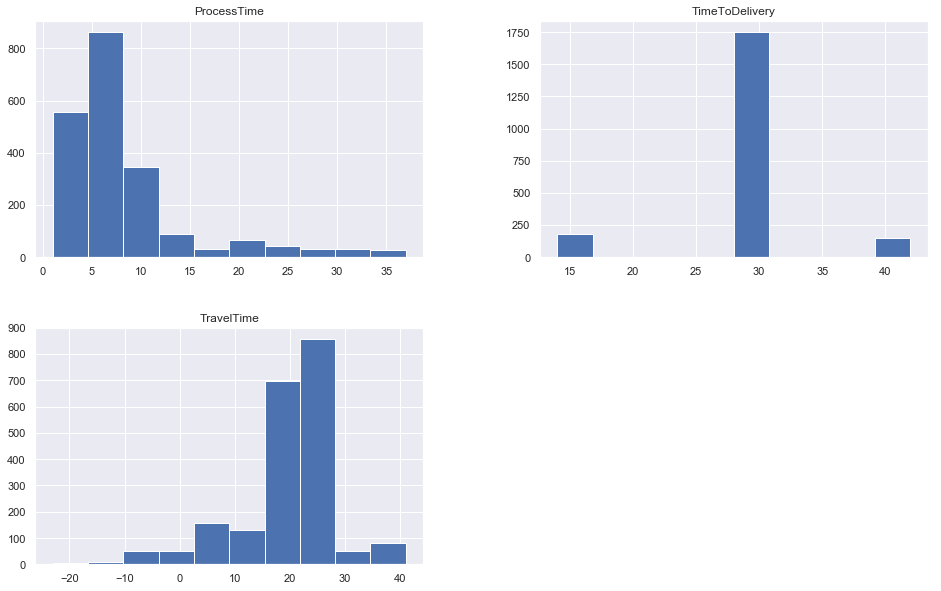

In [53]:
#histogram for ['OrderDate', 'ShippedDate', 'RequiredDate']
test_df2[['ProcessTime', 'TimeToDelivery', 'TravelTime']].hist(figsize=(16, 10));

Negative TraveTime? We shall explore!

In [54]:
# filtering the dataframe to display only orders with a negative travel time and units in stock.
test_df2[(test_df2['TravelTime'] < 0) & (test_df2['UnitsInStock'] <= 0)]

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
395,10423,2013-01-23,2013-02-06,2013-02-24,10423,31,Gorgonzola Telino,31,0,70,20,32.0,-18.0,14
411,10705,2013-10-15,2013-11-12,2013-11-18,10705,31,Gorgonzola Telino,31,0,70,20,34.0,-6.0,28
757,10380,2012-12-12,2013-01-09,2013-01-16,10380,53,Perth Pasties,53,0,0,0,35.0,-7.0,28
1137,10302,2012-09-10,2012-10-08,2012-10-09,10302,17,Alice Mutton,17,0,0,0,29.0,-1.0,28
1146,10523,2013-05-01,2013-05-29,2013-05-30,10523,17,Alice Mutton,17,0,0,0,29.0,-1.0,28
1156,10727,2013-11-03,2013-12-01,2013-12-05,10727,17,Alice Mutton,17,0,0,0,32.0,-4.0,28
1280,10687,2013-09-30,2013-10-28,2013-10-30,10687,29,Thüringer Rostbratwurst,29,0,0,0,30.0,-2.0,28


In [55]:
# sorting values by Id_x(OrderId) to to see which product is holding up the processing time
test_df2.sort_values(by=['Id_x'])

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
0,10248,2012-07-04,2012-08-01,2012-07-16,10248,11,Queso Cabrales,11,22,30,30,12.0,16.0,28
68,10248,2012-07-04,2012-08-01,2012-07-16,10248,72,Mozzarella di Giovanni,72,14,0,0,12.0,16.0,28
38,10248,2012-07-04,2012-08-01,2012-07-16,10248,42,Singaporean Hokkien Fried Mee,42,26,0,0,12.0,16.0,28
106,10249,2012-07-05,2012-08-16,2012-07-10,10249,14,Tofu,14,35,0,0,5.0,37.0,42
128,10249,2012-07-05,2012-08-16,2012-07-10,10249,51,Manjimup Dried Apples,51,20,0,10,5.0,37.0,42
129,10250,2012-07-08,2012-08-05,2012-07-12,10250,51,Manjimup Dried Apples,51,20,0,10,4.0,24.0,28
167,10250,2012-07-08,2012-08-05,2012-07-12,10250,41,Jack's New England Clam Chowder,41,85,0,10,4.0,24.0,28
214,10250,2012-07-08,2012-08-05,2012-07-12,10250,65,Louisiana Fiery Hot Pepper Sauce,65,76,0,0,4.0,24.0,28
215,10251,2012-07-08,2012-08-05,2012-07-15,10251,65,Louisiana Fiery Hot Pepper Sauce,65,76,0,0,7.0,21.0,28
246,10251,2012-07-08,2012-08-05,2012-07-15,10251,22,Gustaf's Knäckebröd,22,104,0,25,7.0,21.0,28


### Out of STOCK!
The negative travel times are due to Northwind not having enough in inventory to fulfill the order. We shall explore in hypothesis 3 if the amount in stock is enough to fulfill their orders.

### Hypothesis Test

We shall now explore to see if having missed orders are significant.

> $H_0 \leq 5$ H0: The mean percentage of late shipments is <= 5%

> $H_1 >$ 5% H1: The mean percentage of late shipments is > 5%

In [56]:
from scipy import stats

In [57]:
# create a random sample of 
travel_arr = np.empty(shape=10000)
for i in range(10000):
    travel_sample = np.random.choice(test_df2['TravelTime'], len(test_df2['TravelTime']))
    travel_arr[i] = np.sum(travel_sample < 0) / travel_sample.size
travel_mu = np.mean(travel_arr)
travel_std = np.std(travel_arr)
print(f'distribution mean: {travel_mu}')
print(f'standard distribution: {travel_std}')

distribution mean: 0.044116186359269935
standard distribution: 0.004491697798019384


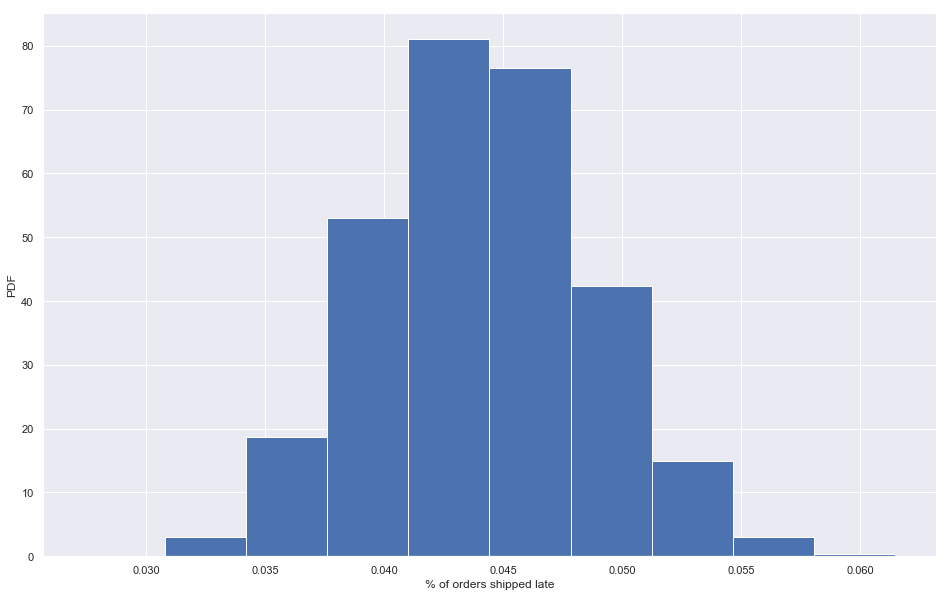

In [91]:
#creating a probability density
_ = plt.figure(figsize=(16, 10))
_ = plt.hist(travel_arr, bins=10, normed=True)
_ = plt.xlabel('% of orders shipped late')
_ = plt.ylabel('PDF')
plt.show();

In [59]:
x, y = ecdf(test_df2['TravelTime'])

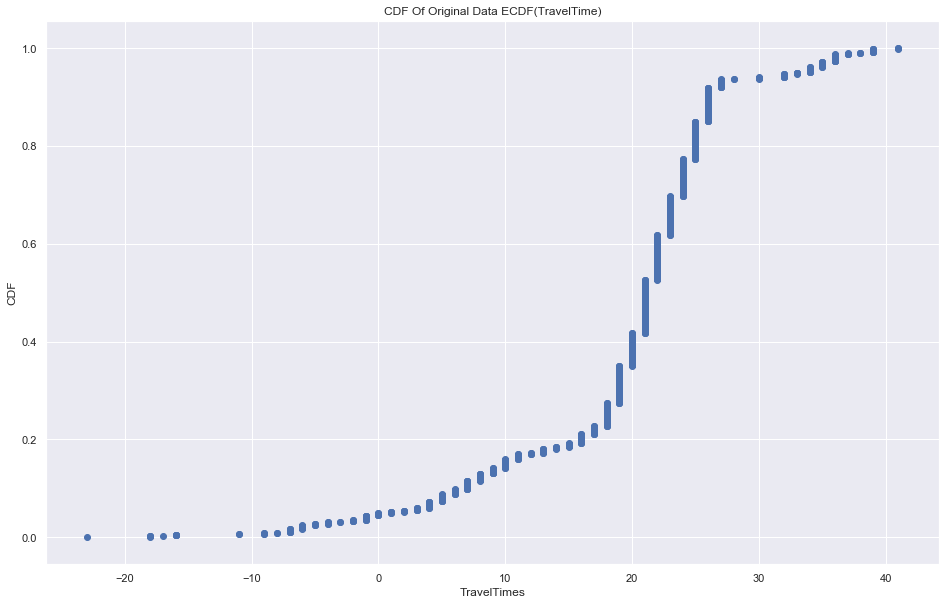

In [60]:
_ = plt.figure(figsize=(16, 10))
_ = plt.scatter(x=x, y=y)
_ = plt.xlabel('TravelTimes')
_ = plt.ylabel('CDF')
_ = plt.title('CDF Of Original Data ECDF(TravelTime)')
plt.show()

Standard Error of Mean: 0.004504010187006331
Standard deviation: 0.0045186072038273664
Mean: 0.044198174831892416


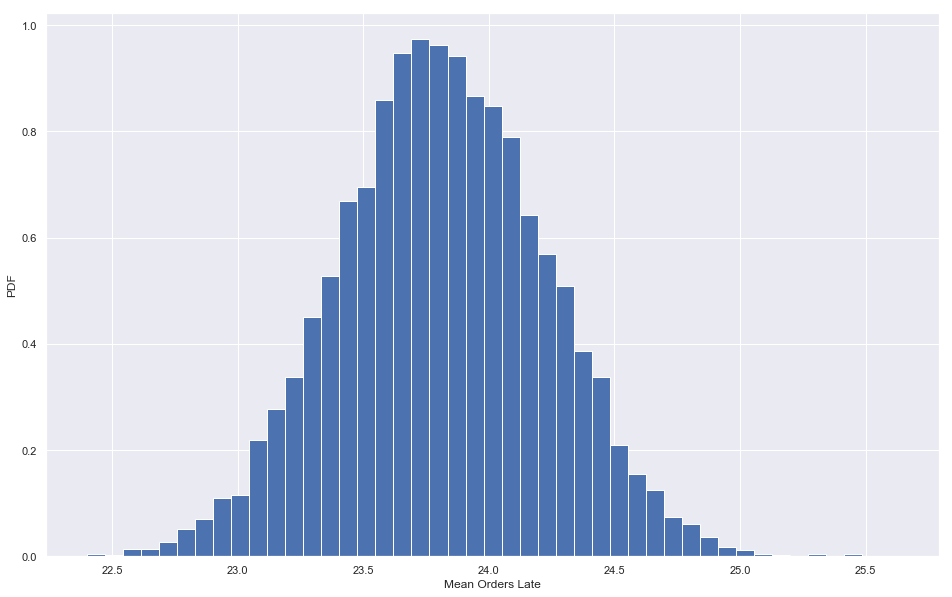

In [179]:
TravelTime = test_df2['TravelTime'] < 0 / test_df2['TravelTime'].size
# take 10000 mean replicas from Quantity
time_replicas = simulate(TravelTime, np.mean, 10000)

# computing the standard error of the mean
sem = np.std(TravelTime) / np.sqrt(len(TravelTime))
print(f'Standard Error of Mean: {sem}')

std_replicas = np.std(time_replicas)
print(f'Standard deviation: {std_replicas}')
time_mu = np.mean(time_replicas)
print(f'Mean: {time_mu}')

# Histogram to show results
_ = plt.figure(figsize=(16, 10))
_ = plt.hist(qty_replicas, bins=int(np.sqrt(len(TravelTime))), density=True)
_ = plt.xlabel('Mean Orders Late')
_ = plt.ylabel('PDF')

plt.show()

In [207]:
def p_value(data, mu):
    '''
    Display P-value for a dataset for a given mean.
    
    data: array-like
    mu: mean of data
    '''
    t, p = stats.ttest_1samp(data, mu)
    
    if p/2 <= 0.05:
        return f'P-value of {p/2}, Reject the null hypothesis'
    else:
        return f'P-value of {p/2}, fail to reject the null hypothesis'

In [92]:
mu = round(np.mean(test_df2['TravelTime']),2)
print(f'The mean for TravelTime is {mu}.')
std = np.std(test_df2['TravelTime'], ddof=1)
print(f'The standard dieviation for TravelTime is {std}.')

The mean for TravelTime is 19.47.
The standard dieviation for TravelTime is 8.848344404437842.


In [102]:
p_value(test_df2['TravelTime'] < 0, time_mu)

'P-value of 0.49802671557222944, fail to reject the null hypothesis'

Since we have failed to reject the null hypothesis of processing times taking longer than expected, let us dig deeper into the orders that had processing times that caused orders to be shipped late.

### Hypothesis 3:

> $H_0 \leq \mu_0$ $H_0$: UnitsOnOrder mean is less than or equal to 70

> $H_1 > \mu_1$ $H_1$: UnitsOnOrder mean is greater than 70

In [114]:
late_ship = test_df2[(test_df2['TravelTime'] < 0) & (test_df2['UnitsInStock'] <= 0)]
late_ship.head()

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
395,10423,2013-01-23,2013-02-06,2013-02-24,10423,31,Gorgonzola Telino,31,0,70,20,32.0,-18.0,14
411,10705,2013-10-15,2013-11-12,2013-11-18,10705,31,Gorgonzola Telino,31,0,70,20,34.0,-6.0,28
757,10380,2012-12-12,2013-01-09,2013-01-16,10380,53,Perth Pasties,53,0,0,0,35.0,-7.0,28
1137,10302,2012-09-10,2012-10-08,2012-10-09,10302,17,Alice Mutton,17,0,0,0,29.0,-1.0,28
1146,10523,2013-05-01,2013-05-29,2013-05-30,10523,17,Alice Mutton,17,0,0,0,29.0,-1.0,28


In [182]:
gorgonzola_telino = test_df2[test_df2['ProductId'] == 31]
gorgonzola_telino.head()

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
382,10253,2012-07-10,2012-07-24,2012-07-16,10253,31,Gorgonzola Telino,31,0,70,20,6.0,8.0,14
383,10272,2012-08-02,2012-08-30,2012-08-06,10272,31,Gorgonzola Telino,31,0,70,20,4.0,24.0,28
384,10273,2012-08-05,2012-09-02,2012-08-12,10273,31,Gorgonzola Telino,31,0,70,20,7.0,21.0,28
385,10325,2012-10-09,2012-10-23,2012-10-14,10325,31,Gorgonzola Telino,31,0,70,20,5.0,9.0,14
386,10335,2012-10-22,2012-11-19,2012-10-24,10335,31,Gorgonzola Telino,31,0,70,20,2.0,26.0,28


In [145]:
type(gorgonzola_telino['UnitsOnOrder'])

pandas.core.series.Series

In [128]:
gorgonzola_telino[gorgonzola_telino['UnitsInStock'] > 0]

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery


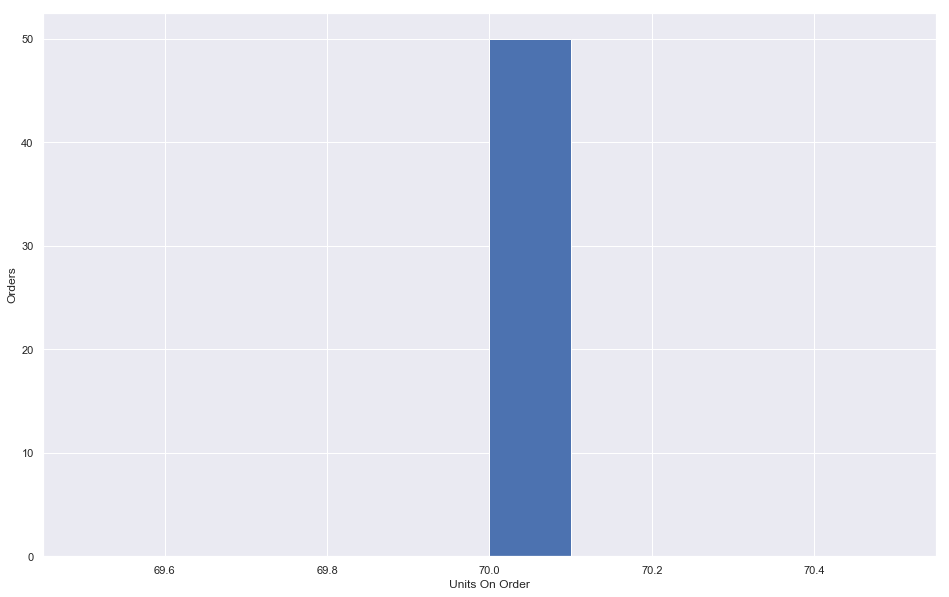

In [158]:
_ = plt.figure(figsize=(16, 10))
_ = plt.hist(gorgonzola_telino['UnitsOnOrder'])
_ = plt.xlabel('Units On Order')
_ = plt.ylabel('Orders')
plt.show()

There is never a healthy supply of Gorgonzola Telino, let's take a look at the the other items that are on backorder.

In [129]:
perth_pasties = test_df2[test_df2['ProductId'] == 53]
perth_pasties.head()

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
753,10256,2012-07-15,2012-08-12,2012-07-17,10256,53,Perth Pasties,53,0,0,0,2.0,26.0,28
754,10285,2012-08-20,2012-09-17,2012-08-26,10285,53,Perth Pasties,53,0,0,0,6.0,22.0,28
755,10306,2012-09-16,2012-10-14,2012-09-23,10306,53,Perth Pasties,53,0,0,0,7.0,21.0,28
756,10312,2012-09-23,2012-10-21,2012-10-03,10312,53,Perth Pasties,53,0,0,0,10.0,18.0,28
757,10380,2012-12-12,2013-01-09,2013-01-16,10380,53,Perth Pasties,53,0,0,0,35.0,-7.0,28


In [150]:
alice_mutton = test_df2[test_df2['ProductId'] == 17]
alice_mutton.head()

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery
1134,10265,2012-07-25,2012-08-22,2012-08-12,10265,17,Alice Mutton,17,0,0,0,18.0,10.0,28
1135,10279,2012-08-13,2012-09-10,2012-08-16,10279,17,Alice Mutton,17,0,0,0,3.0,25.0,28
1136,10294,2012-08-30,2012-09-27,2012-09-05,10294,17,Alice Mutton,17,0,0,0,6.0,22.0,28
1137,10302,2012-09-10,2012-10-08,2012-10-09,10302,17,Alice Mutton,17,0,0,0,29.0,-1.0,28
1138,10319,2012-10-02,2012-10-30,2012-10-11,10319,17,Alice Mutton,17,0,0,0,9.0,19.0,28


In [139]:
alice_mutton[alice_mutton['UnitsOnOrder'] > 0]

,Id_x,OrderDate,RequiredDate,ShippedDate,OrderId,ProductId,ProductName,Id_y,UnitsInStock,UnitsOnOrder,ReorderLevel,ProcessTime,TravelTime,TimeToDelivery


### Finding Orders Per Week

In [183]:
gorgonzola_telino['OrderDate'] = gorgonzola_telino['OrderDate'].dt.week
gorgonzola_telino.set_index('OrderDate', inplace=True)

In [187]:
weeks = gorgonzola_telino.groupby(by='OrderDate')

In [196]:
# looking to how many orders are placed during each month.
# we know that each order contains 70 units and the reorder level is 20.

#Using the .agg() method to show the size(how many orders per week), sum, and mean of each week.
weeks['UnitsOnOrder'].agg(['size', 'sum', 'mean'])

,size,sum,mean
OrderDate,,,
1,1,70,70
2,1,70,70
3,1,70,70
4,1,70,70
5,1,70,70
7,2,140,70
11,4,280,70
12,1,70,70
13,1,70,70


### Hacker Statistics

To find the true mean of the data we'll use hacker statistics again to do 10,000 simulations of the data.

In [199]:
gorgonzola_sample = simulate(gorgonzola_telino['UnitsOnOrder'], np.mean, 10000)

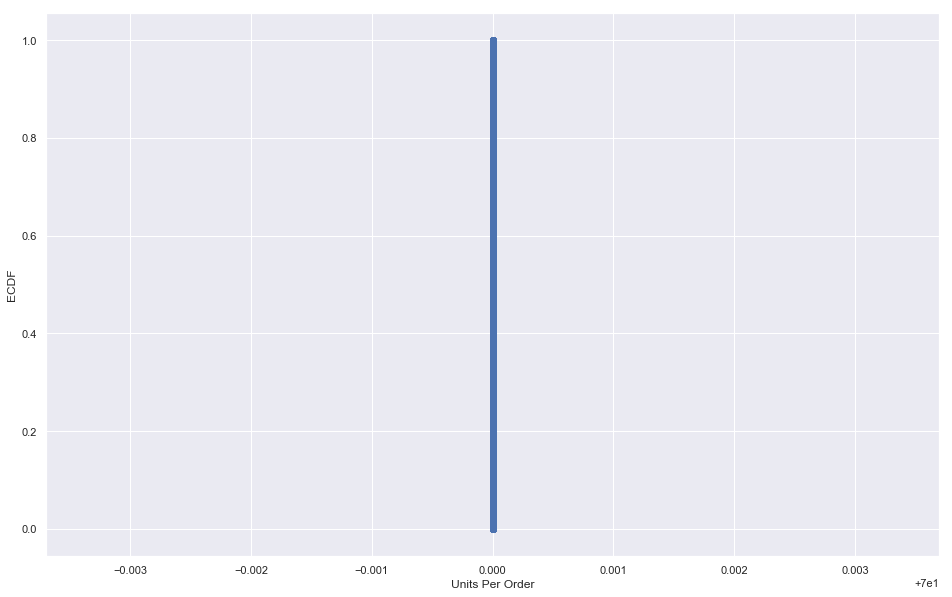

In [202]:
x, y = ecdf(gorgonzola_sample)
_ = plt.figure(figsize=(16, 10))
_ = plt.scatter(x=x, y=y)
_ = plt.xlabel('Units Per Order')
_ = plt.ylabel('ECDF')
plt.show();

In [203]:
# computing the true mean of the distribution sample
gorgonzola_mean = np.mean(gorgonzola_sample)

### Permutation Test

In [204]:
permutation_arr = np.empty(10000)

for i in range(10000):
    sample = np.random.permutation(gorgonzola_telino['UnitsOnOrder'])
    permutation_arr[i] = np.mean(sample)
p_value = np.sum(permutation_arr <= gorgonzola_mean) / len(permutation_arr)

if p_value <= 0.05:
    print(f'P-value: {p_value}, Reject null hypothesis')
else:
    print(f'P-value: {p_value}, Fail to reject null hypothesis')

P-value: 1.0, Fail to reject null hypothesis


### T-test using scipy

In [215]:
stats.ttest_1samp(gorgonzola_telino['UnitsOnOrder'], 70)

Ttest_1sampResult(statistic=nan, pvalue=nan)

## Hypothesis 4
